<a href="https://colab.research.google.com/github/navidyamini/TensorFlow2.0_Codes/blob/main/code/TF2_0_Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [30]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [31]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [32]:
# Start by doing the WRONG thing -trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [33]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [34]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(x)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (1249, 10, 1) Y.shape (1249,)


In [35]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
39/39 [==============================] - 3s 21ms/step - loss: 2.6162 - val_loss: 2.9415
Epoch 2/80
39/39 [==============================] - 0s 7ms/step - loss: 2.1187 - val_loss: 2.2376
Epoch 3/80
39/39 [==============================] - 0s 7ms/step - loss: 1.6698 - val_loss: 1.6047
Epoch 4/80
39/39 [==============================] - 0s 7ms/step - loss: 1.2587 - val_loss: 1.0402
Epoch 5/80
39/39 [==============================] - 0s 7ms/step - loss: 0.8890 - val_loss: 0.5838
Epoch 6/80
39/39 [==============================] - 0s 7ms/step - loss: 0.5900 - val_loss: 0.2505
Epoch 7/80
39/39 [==============================] - 0s 8ms/step - loss: 0.3764 - val_loss: 0.0742
Epoch 8/80
39/39 [==============================] - 0s 7ms/step - loss: 0.2439 - val_loss: 0.0150
Epoch 9/80
39/39 [==============================] - 0s 7ms/step - loss: 0.1682 - val_loss: 0.0084
Epoch 10/80
39/39 [==============================] - 0s 10ms/step - loss: 0.1259 - val_loss: 0.0256
Epoch 11/80
39/39

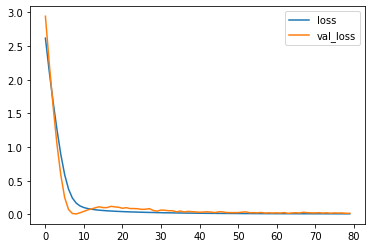

In [36]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

40/40 [==============================] - 1s 4ms/step
(1249, 1)


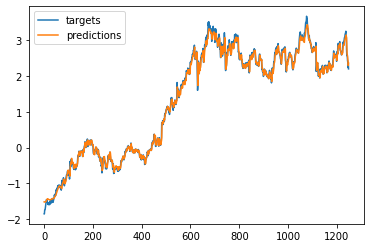

In [37]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 36ms/step


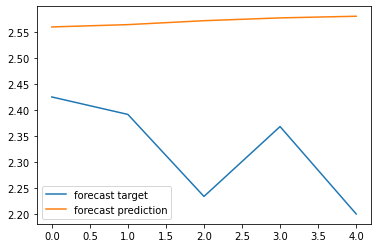

In [38]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array ->

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [39]:
# calculate return by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like 
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [40]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [41]:
# then the return is
# (x[t] -x[t-1]) / x[t-1]
df['Return'] = (df['close'] -df['PrevClose']) / df['PrevClose']

In [42]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


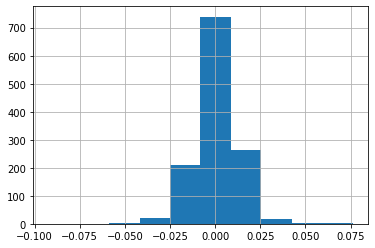

In [43]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [44]:
series = df["Return"].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [45]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(x)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [46]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
39/39 [==============================] - 3s 20ms/step - loss: 1.0573 - val_loss: 2.0301
Epoch 2/80
39/39 [==============================] - 0s 7ms/step - loss: 1.0543 - val_loss: 2.0627
Epoch 3/80
39/39 [==============================] - 0s 8ms/step - loss: 1.0536 - val_loss: 2.0751
Epoch 4/80
39/39 [==============================] - 0s 7ms/step - loss: 1.0524 - val_loss: 2.1381
Epoch 5/80
39/39 [==============================] - 0s 7ms/step - loss: 1.0519 - val_loss: 2.1626
Epoch 6/80
39/39 [==============================] - 0s 7ms/step - loss: 1.0512 - val_loss: 2.1507
Epoch 7/80
39/39 [==============================] - 0s 7ms/step - loss: 1.0501 - val_loss: 2.1720
Epoch 8/80
39/39 [==============================] - 0s 7ms/step - loss: 1.0496 - val_loss: 2.2095
Epoch 9/80
39/39 [==============================] - 0s 7ms/step - loss: 1.0493 - val_loss: 2.1975
Epoch 10/80
39/39 [==============================] - 0s 7ms/step - loss: 1.0488 - val_loss: 2.2048
Epoch 11/80
39/39 

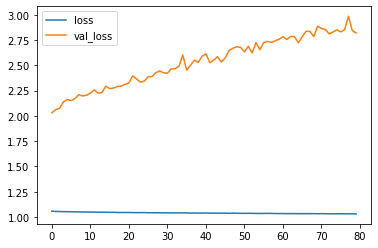

In [47]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

39/39 [==============================] - 1s 2ms/step
(1248, 1)


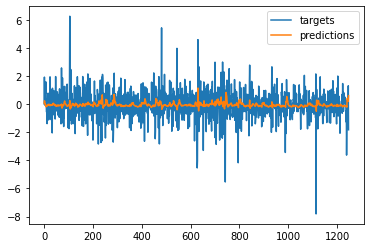

In [48]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 24ms/step


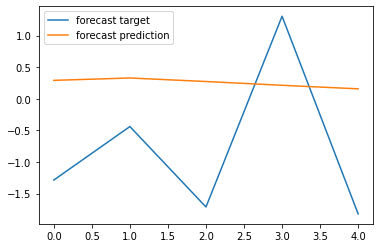

In [49]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array ->

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [53]:
 # Now turn the full data into numpy arrays

 # Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [54]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (eg. if T=10 and you have 11 data points then you'd only have 1)

In [56]:
# nommalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [58]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [59]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [62]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy'],
)

In [63]:
# train the RNN
r = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 4s 38ms/step - loss: 0.6957 - accuracy: 0.5030 - val_loss: 0.6942 - val_accuracy: 0.4829
Epoch 2/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6919 - accuracy: 0.5173 - val_loss: 0.6955 - val_accuracy: 0.4927
Epoch 3/300
27/27 [==============================] - 0s 13ms/step - loss: 0.6925 - accuracy: 0.5125 - val_loss: 0.6971 - val_accuracy: 0.4878
Epoch 4/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6911 - accuracy: 0.5304 - val_loss: 0.6972 - val_accuracy: 0.4829
Epoch 5/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6913 - accuracy: 0.5113 - val_loss: 0.6926 - val_accuracy: 0.5146
Epoch 6/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6897 - accuracy: 0.5268 - val_loss: 0.6946 - val_accuracy: 0.5024
Epoch 7/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6896 - accuracy: 0.5292 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 

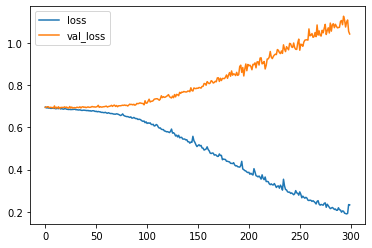

In [64]:
#plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

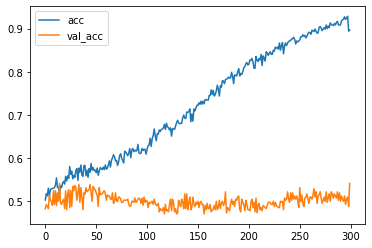

In [65]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()